## Sentiment Analysis on Cannabis Legalization
We will be using **Pattern Analyzer** and **Naive Bayes** algorithms to analyze twitter data on cannabis legalization in Canada, and compare both algorithms.

### Data Cleaning

In [1]:
import json
import re
import pandas as pd


# Open file and store the info
with open('marijuana_tweets.json') as f:
    data = json.load(f)
    
def clean(tweet):
    # Remove hyperlinks and special chars
    return ' '.join(re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', tweet).split())

df = pd.DataFrame()

# Iterate through the data, clean and store the tweets
idx = 0
for d in data:
    df.at[idx, 'full_text'] = d['full_text']
    df.at[idx, 'clean_text'] = clean(d['full_text'])
    df.at[idx, 'created_at'] = clean(d['created_at'])
    df.at[idx, 'user_location'] = clean(d['user']['location'])
    idx += 1

df.head()

,full_text,clean_text,created_at,user_location
0,"Published on October 18, 2018@11:11am: \n\n Ca...",Published on October 18 2018 11am Canada Has L...,Mon Oct 29 01 03 34 0000 2018,United States
1,Hope everyone had a great weekend!\n\nWho's ex...,Hope everyone had a great weekend Who s excite...,Mon Oct 29 00 54 34 0000 2018,Canada
2,"""The problem is that no one knew what the dema...",The problem is that no one knew what the deman...,Mon Oct 29 00 47 00 0000 2018,Canada
3,Here my LinkedIn article on the continued risk...,Here my LinkedIn article on the continued risk...,Mon Oct 29 00 31 10 0000 2018,T 43 770433 79 407727
4,Here my LinkedIn article on the continued risk...,Here my LinkedIn article on the continued risk...,Mon Oct 29 00 30 47 0000 2018,Toronto


### SA using Pattern and Naive Bayes

In [2]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

pattern_analyzer_sentiment = 'PatternAnalyzerSentiment'
naive_bayes_sentiment = 'NaiveBayesSentiment'

for index, row in df.iterrows():
    analysis = TextBlob(row['clean_text'])
    if analysis.sentiment.polarity > 0:     # Positive
        df.loc[index, pattern_analyzer_sentiment] = 1
    elif analysis.sentiment.polarity <= 0:   # Negative
        df.loc[index, pattern_analyzer_sentiment] = 0

nba = NaiveBayesAnalyzer()
for index, row in df.iterrows():
    analysis = TextBlob(row['clean_text'], analyzer=nba)
    if analysis.sentiment.classification == 'pos':
        df.loc[index, naive_bayes_sentiment] = 1
    elif analysis.sentiment.classification == 'neg':
        df.loc[index, naive_bayes_sentiment] = 0

df.PatternAnalyzerSentiment = df.PatternAnalyzerSentiment.astype(int)
df.NaiveBayesSentiment = df.NaiveBayesSentiment.astype(int)
df.head()

,full_text,clean_text,created_at,user_location,PatternAnalyzerSentiment,NaiveBayesSentiment
0,"Published on October 18, 2018@11:11am: \n\n Ca...",Published on October 18 2018 11am Canada Has L...,Mon Oct 29 01 03 34 0000 2018,United States,0,0
1,Hope everyone had a great weekend!\n\nWho's ex...,Hope everyone had a great weekend Who s excite...,Mon Oct 29 00 54 34 0000 2018,Canada,1,0
2,"""The problem is that no one knew what the dema...",The problem is that no one knew what the deman...,Mon Oct 29 00 47 00 0000 2018,Canada,0,0
3,Here my LinkedIn article on the continued risk...,Here my LinkedIn article on the continued risk...,Mon Oct 29 00 31 10 0000 2018,T 43 770433 79 407727,0,1
4,Here my LinkedIn article on the continued risk...,Here my LinkedIn article on the continued risk...,Mon Oct 29 00 30 47 0000 2018,Toronto,0,1


### Some Charts and Comparison

#### Word Cloud

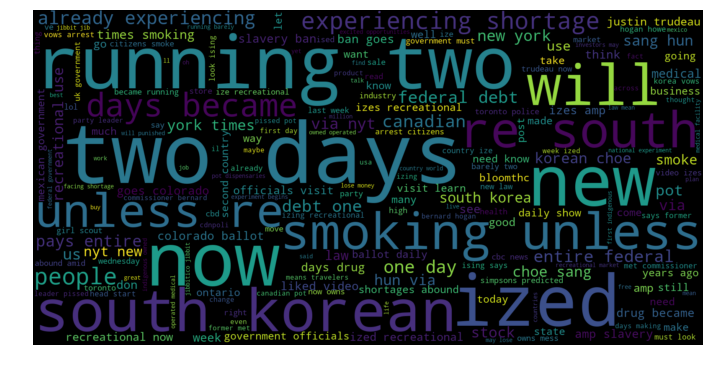

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all the tweets in a single text
wordcloud_texts = ' '.join(df['clean_text'].tolist()).lower()
# Remove the obvious words
remove_words = 'marijuana|legal|ization|weed|canada|cannabi'
wordcloud_texts = re.sub(remove_words, '', wordcloud_texts)

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(wordcloud_texts)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Pie Charts

In [8]:
def plot_pie_chart(positive_count, negative_count):
    # Data to plot
    labels = 'Positive', 'Negative'
    sizes = [positive_count, negative_count]
    colors = ['yellowgreen', 'lightcoral']
    explode = (0.1, 0)  # explode 1st slice

    # Plot
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title('Twitter Reaction on Cannabis Legalization')
    plt.axis('equal')
    plt.rcParams["figure.figsize"] = (10, 6)
    plt.show()

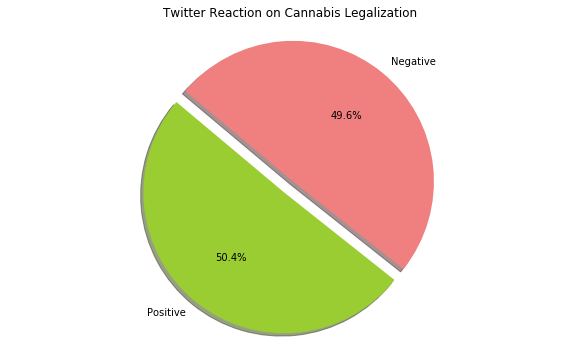

In [11]:
plot_pie_chart(df[pattern_analyzer_sentiment].value_counts()[1], df[pattern_analyzer_sentiment].value_counts()[0])

Pie chart when using **pattern analyzer**

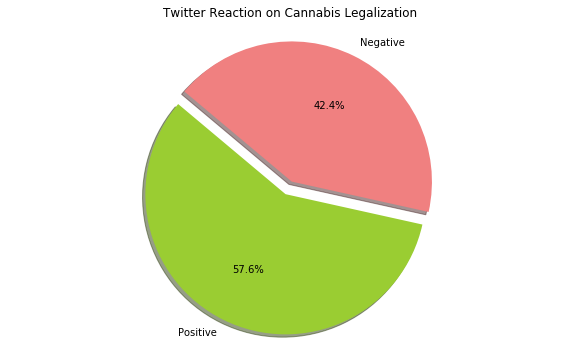

In [10]:
plot_pie_chart(df[navive_bayes_sentiment].value_counts()[1], df[naive_bayes_sentiment].value_counts()[0])

Pie chart when using **Naive Bayes**

In [24]:
import numpy as np

def get_sentiment_count_on_location(loc_list, analyzer):
    pos_count = df.loc[(df['user_location'].isin(loc_list)) & (df[analyzer] ==  1)].count()['full_text']
    neg_count = df.loc[(df['user_location'].isin(loc_list)) & (df[analyzer] ==  0)].count()['full_text']
    return (pos_count, neg_count)

def plot_sentiment_countries_bar_chart(analyzer):
    usa_list = ['USA', 'United States', 'California USA', 'Los Angeles CA', 'New York NY', 'Arizona Desert',
                'Las Vegas San Francisco London', 'Washington DC', 'Chicago IL', 'Denver CO', 'Seattle WA']
    canada_list = ['Canada', 'Toronto Ontario', 'Vancouver British Columbia', 'Ontario Canada', 'Toronto Canada']

    usa_sentiment = get_sentiment_count_on_location(usa_list, analyzer)
    canada_sentiment = get_sentiment_count_on_location(canada_list, analyzer)
    australia_sentiment = get_sentiment_count_on_location(['Australia'], analyzer)
    nigeria_sentiment = get_sentiment_count_on_location(['Lagos Nigeria', 'Nigeria'], analyzer)
    england_sentiment = get_sentiment_count_on_location(['London England', 'London'], analyzer)
    kenya_sentiment = get_sentiment_count_on_location(['Nairobi Kenya'], analyzer)

    positives = (usa_sentiment[0], canada_sentiment[0], australia_sentiment[0], nigeria_sentiment[0],
                 england_sentiment[0], kenya_sentiment[0])
    negatives = (usa_sentiment[1], canada_sentiment[1], australia_sentiment[1], nigeria_sentiment[1],
                 england_sentiment[1], kenya_sentiment[1])

    ind = np.arange(len(positives))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width/2, positives, width,
                    color='mediumseagreen', label='Positive')
    rects2 = ax.bar(ind + width/2, negatives, width,
                    color='IndianRed', label='Negative')
    ax.set_ylabel('Sentiment Count')
    ax.set_title('Sentiments by countries')
    ax.set_xticks(ind)
    ax.set_xticklabels(('USA', 'Canada', 'Australia', 'Nigeria', 'England', 'Kenya'))
    ax.legend()

    def autolabel(rects, xpos='center'):
        xpos = xpos.lower()  # normalize the case of the parameter
        ha = {'center': 'center', 'right': 'left', 'left': 'right'}
        offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1*height,
                    '{}'.format(height), ha=ha[xpos], va='bottom')

    autolabel(rects1, "left")
    autolabel(rects2, "right")
    plt.rcParams["figure.figsize"] = (10, 6)
    plt.show()

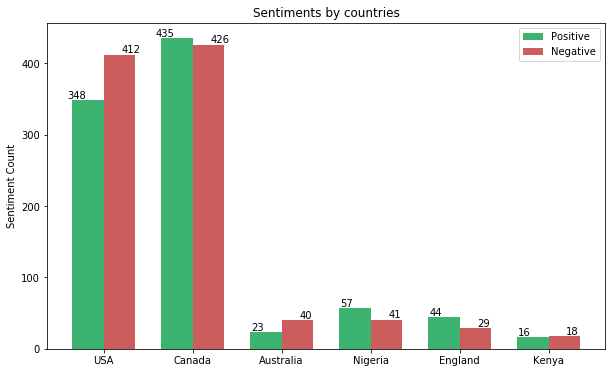

In [25]:
plot_sentiment_countries_bar_chart(pattern_analyzer_sentiment)

Bar chart when **Pattern Analyzer** algorithm was used


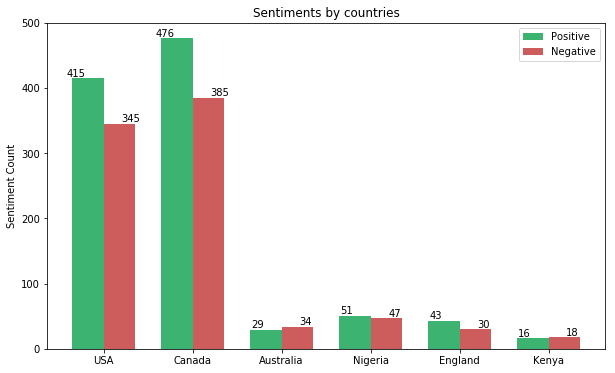

In [21]:
plot_sentiment_countries_bar_chart(naive_bayes_sentiment)

Bar chart when **Naive Bayes** algorithm was used